In [1]:
from mpl_toolkits.mplot3d import Axes3D
import deepblink as pink
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage.io
import trackpy as tp

tp.quiet()

In [2]:
!deepblink download -i particle

# 3D Prediction: combining predictions from single stacks

deepBlink is only able to predict on a single 2D image at a time. Therefore, we have to tweak our workflow a little bit if 3D prediction should be performed.

Here we will use [trackpy](https://soft-matter.github.io/trackpy/dev/index.html) to do some of the heavy liftings.

### Step 1: Loading image and model

First, let's begin by loading a pre-trained model and example image into memory using deepBlink and scikit-image respectively.

In [3]:
image = skimage.io.imread("./image.tif")
image.shape

(16, 512, 512)

In [4]:
model = pink.io.load_model("./particle.h5")

### Step 2: Spot detection¶

Next, we can go through all slices along the z-axis individually using the `deepblink.inference.predict` function. We will save all predictions into a single `pandas.DataFrame` to which we'll add the current slice.

To gather some data on each spot, we can use `trackpy.refine_com` to get the following:
* mass: total integrated brightness of the blob
* size: radius of gyration of its Gaussian-like profile
* ecc: eccentricity (0 is circular)
* signal: intensity of signal
* raw_mass: total integrated brightness (raw image)

However, we don't want to refine the spots so we subsequently replace the x and y columns.

In [5]:
radius_refinement = 3

In [6]:
df = pd.DataFrame()
pad_width = radius_refinement

for slice, image_curr in enumerate(image):
    # deepBlink prediction
    yx = pink.inference.predict(image=image_curr, model=model)
    y, x = yx.T.copy()

    # pad to avoid error for spot close to the edges
    yx = yx + pad_width
    image_curr = np.pad(
        image_curr, pad_width=pad_width, mode='constant', constant_values = 0
    )
    
    # Refinement with trackpy
    df_curr = tp.refine_com(
        raw_image=image_curr, image=image_curr, radius=radius_refinement, coords=yx
    )
    df_curr["x"] = x
    df_curr["y"] = y
    df_curr["slice"] = slice
    df = df.append(df_curr, ignore_index=True)

df

,y,x,mass,size,ecc,signal,raw_mass,slice
0,25.646484,58.133535,859.0,2.044898,0.075699,48.0,859.0,0
1,26.968888,89.922246,868.0,2.051188,0.039871,46.0,868.0,0
2,26.600584,178.641126,864.0,2.050858,0.033927,45.0,864.0,0
3,27.285306,364.561547,817.0,2.007331,0.086879,49.0,817.0,0
4,27.732802,385.838732,881.0,2.022855,0.039481,46.0,881.0,0
...,...,...,...,...,...,...,...,...
4154,481.948924,272.684404,885.0,2.063402,0.072653,49.0,885.0,15
4155,481.832174,363.418544,895.0,1.997484,0.103791,57.0,895.0,15
4156,483.724480,391.803128,872.0,1.993683,0.092126,50.0,872.0,15
4157,480.534180,449.081928,828.0,2.038281,0.057931,42.0,828.0,15


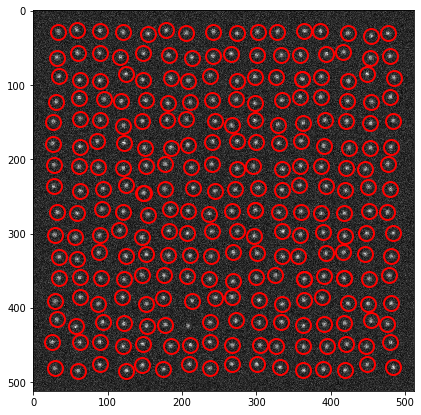

In [7]:
plt.figure(figsize=(7, 7))
tp.annotate(df[df["slice"] == 0], image[0]);

### Step 3: Non-maximum suppression

We now want to merge spots that are located above / below each other respectively as we would otherwise double-count a single spot. This will heavily depend on your axial resolution in Z. If your slices are farther apart than the average spot diameter this step can be skipped.

We'll use trackpy to link spots along the z-axis in a narrow radius as we don't expect spots to move in x/y between slices.

In [8]:
search_range = 2
gap_frames = 0
min_frames = 2

track = tp.link(
    df.rename({"slice": "frame"}, axis=1),
    search_range=search_range,
    memory=gap_frames,
)
track = tp.filter_stubs(track, threshold=min_frames).rename({"frame": "slice"}, axis=1)

We now have all spots that were detected on multiple slices. The next step will be to find the center of mass of each spot. For each particle, the brightest slice (highest intensity) will be chosen. One could also do a 1D Gaussian fitting along the z-axis. However, if one wants to index or reference back to the original image, integers are easier to work with than floats.

In [9]:
# Index of brightest particles
idx = track.groupby(["particle"])["mass"].transform(max) == track["mass"]

# Remove non-brightest spots from all spots
df_clean = pd.concat(
    [
        df[~df.isin(track.drop(["slice"], axis=1).reset_index())]
        .dropna()
        .reset_index(drop=True),
        track[idx],
    ]
)
df_clean

,y,x,mass,size,ecc,signal,raw_mass,slice,particle
0,25.646484,58.133535,859.0,2.044898,0.075699,48.0,859.0,0,NaN
1,26.968888,89.922246,868.0,2.051188,0.039871,46.0,868.0,0,NaN
2,26.600584,178.641126,864.0,2.050858,0.033927,45.0,864.0,0,NaN
3,27.285306,364.561547,817.0,2.007331,0.086879,49.0,817.0,0,NaN
4,27.732802,385.838732,881.0,2.022855,0.039481,46.0,881.0,0,NaN
...,...,...,...,...,...,...,...,...,...
15,207.780566,358.549707,862.0,2.021635,0.096123,53.0,862.0,15,3508.0
15,212.250740,85.204320,848.0,2.004417,0.045782,52.0,848.0,15,3492.0
15,243.014977,150.753928,864.0,2.049447,0.045162,52.0,864.0,15,3502.0
15,175.517060,32.854902,851.0,2.023656,0.041726,47.0,851.0,15,3524.0


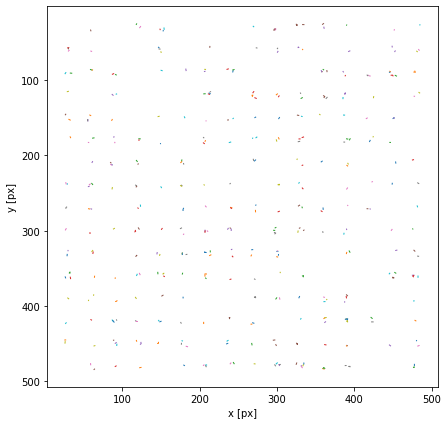

In [10]:
plt.figure(figsize=(7, 7))
tp.plot_traj(track.rename({"slice": "frame"}, axis=1));

Note that the plotted tracks above in the `pd.DataFrame` `track` only consist of particles found in multiple slices. If you know your axial resolution is low enough to capture spots on multiple slices, you can use `track` as spots only occurring in a single slice have been filtered out. If you only want to remove double/multi-detected spots, proceed with `df`. 

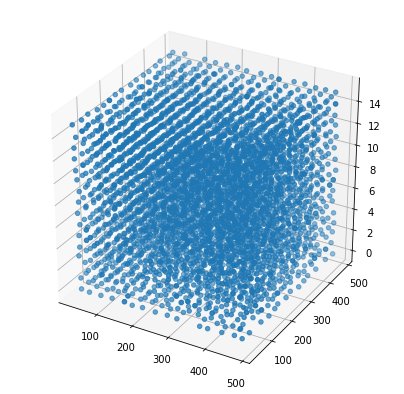

In [11]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(df_clean["x"], df_clean["y"], df_clean["slice"])
plt.show()